# **Install and Import Required Libraries**

In [2]:
# pip install yfinance
import yfinance as yf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
from datetime import datetime

# **Data Collection**

In [4]:
# Set the date range
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

# Download stock data
stock = "GOOG"
google_data = yf.download(stock, start, end)


[*********************100%***********************]  1 of 1 completed


# **Data Exploration**

In [5]:
# Explore the data
print(google_data.head())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2004-08-30  2.622171  2.627402  2.540727  2.540727   2.537839  104429967
2004-08-31  2.547950  2.583068  2.544463  2.549693   2.546795   98825037
2004-09-01  2.557912  2.564637  2.482445  2.496891   2.494053  183633734
2004-09-02  2.470490  2.549693  2.464263  2.528273   2.525399  303810504
2004-09-03  2.514326  2.534002  2.473728  2.490913   2.488082  103538639


In [6]:
# Explore the data
# print(google_data.head())
print(google_data.shape)

(5035, 6)


In [7]:
print(google_data.describe())

              Open         High          Low        Close    Adj Close  \
count  5035.000000  5035.000000  5035.000000  5035.000000  5035.000000   
mean     45.837481    46.322075    45.380269    45.859912    45.810044   
std      43.970318    44.458862    43.541411    44.005998    43.962665   
min       2.470490     2.534002     2.464263     2.490913     2.488082   
25%      13.075988    13.185079    12.925427    13.079102    13.064235   
50%      27.086136    27.355499    26.901142    27.082645    27.051861   
75%      60.770250    61.302200    60.225750    60.797501    60.728394   
max     191.750000   193.309998   190.619995   192.660004   192.660004   

             Volume  
count  5.035000e+03  
mean   1.149927e+08  
std    1.491558e+08  
min    1.584340e+05  
25%    2.719245e+07  
50%    5.451959e+07  
75%    1.415506e+08  
max    1.650833e+09  


In [8]:
print(google_data.info())
print(google_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2004-08-30 to 2024-08-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5035 non-null   float64
 1   High       5035 non-null   float64
 2   Low        5035 non-null   float64
 3   Close      5035 non-null   float64
 4   Adj Close  5035 non-null   float64
 5   Volume     5035 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.4 KB
None
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# **Data Visualisation**

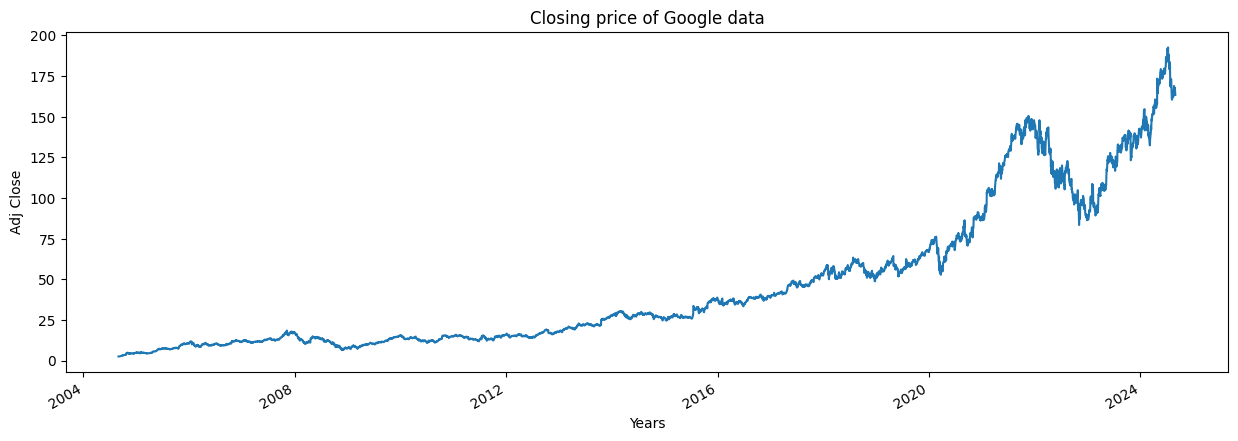

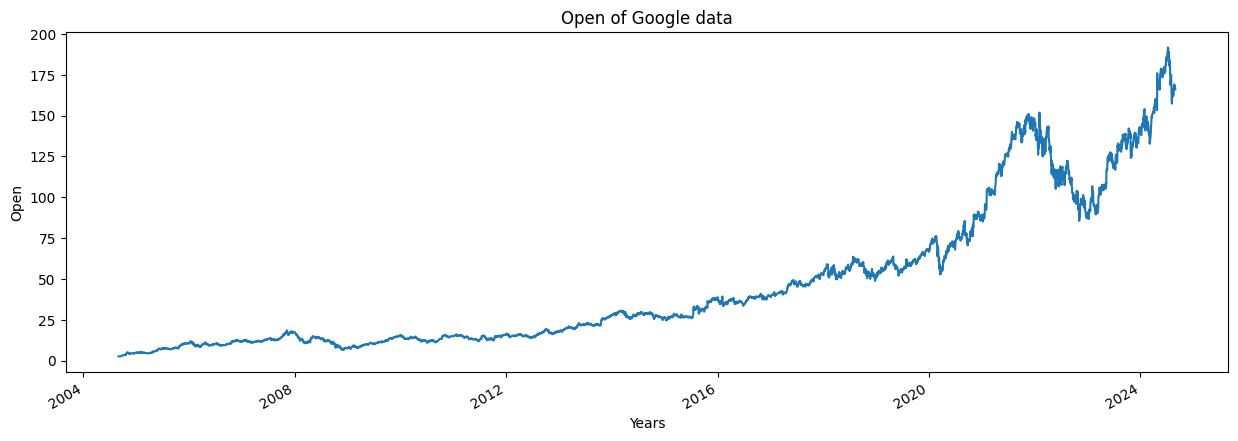

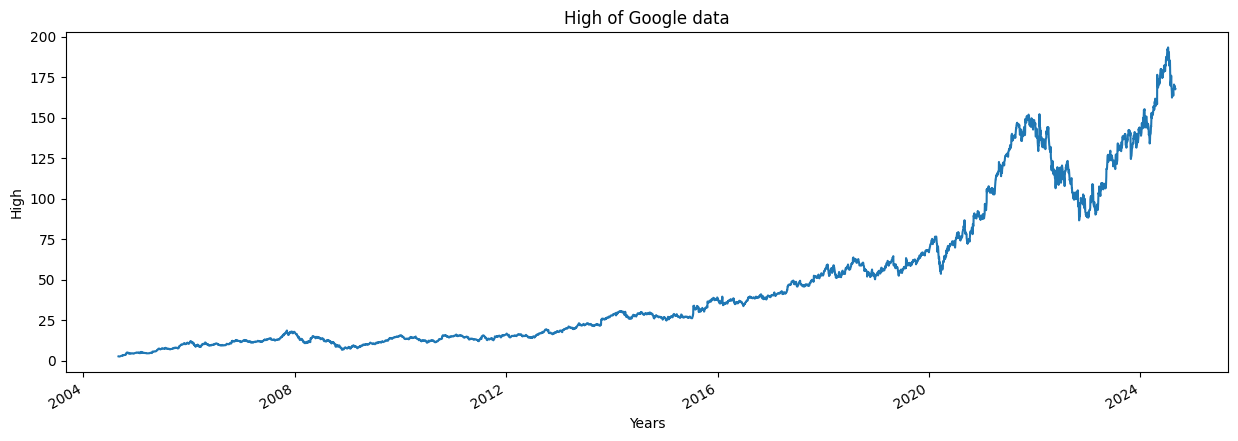

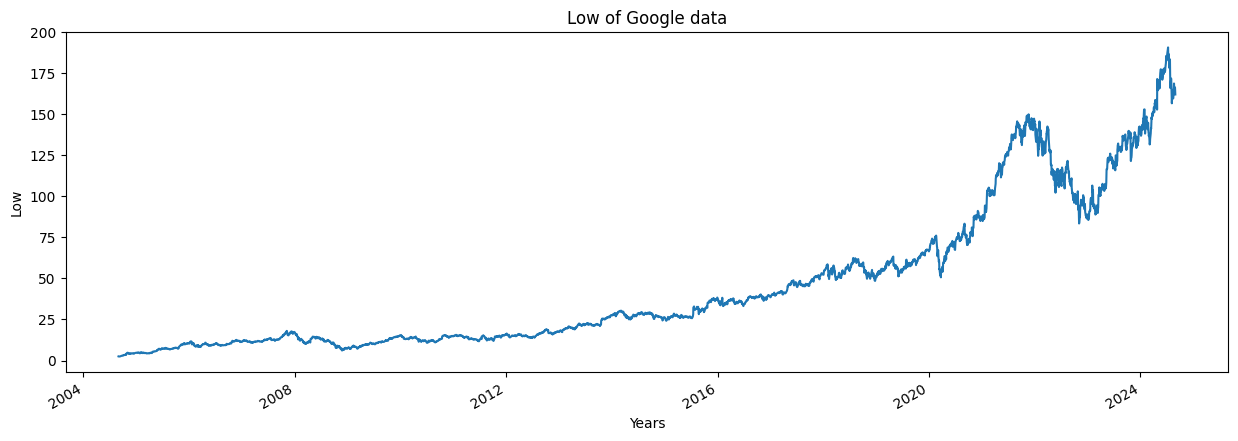

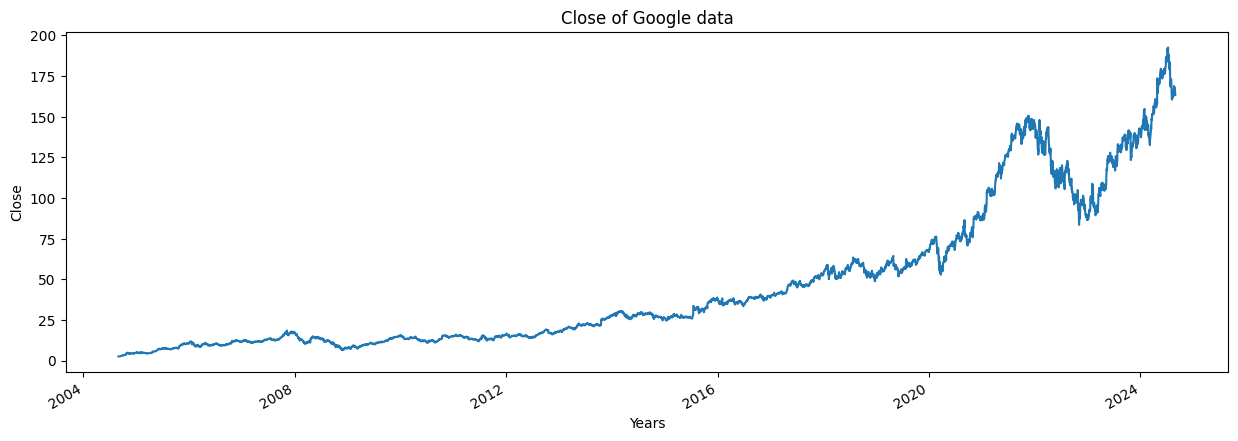

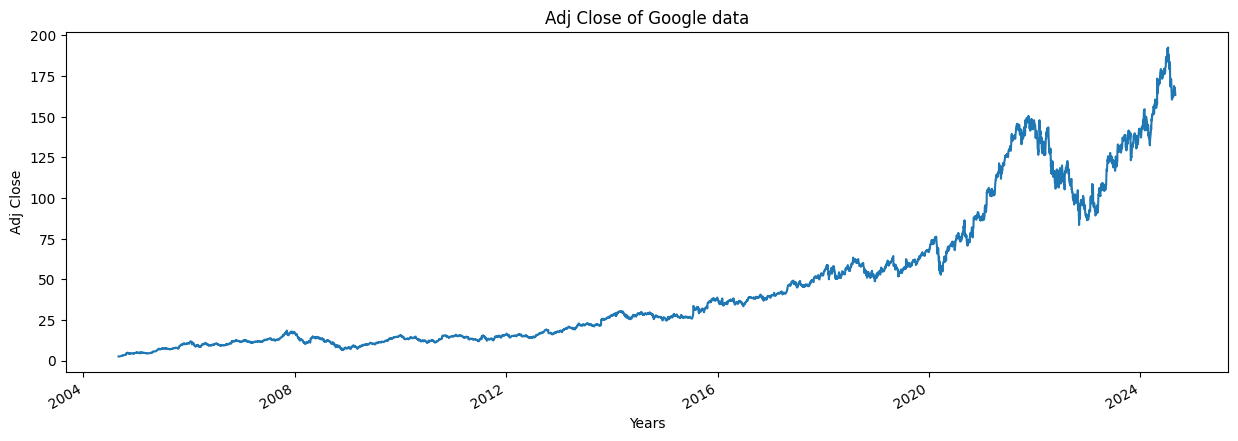

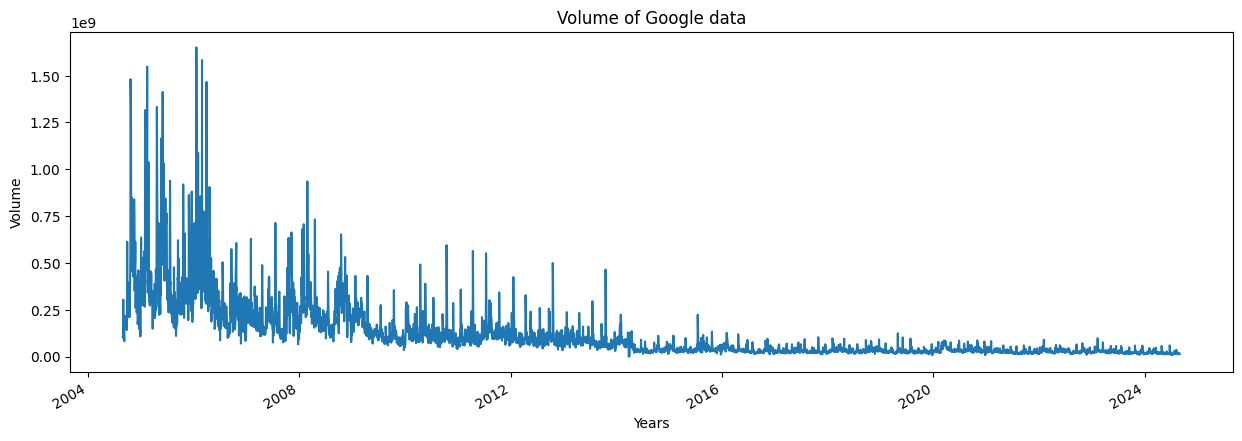

In [9]:
# Plot the 'Adj Close' price
plt.figure(figsize=(15, 5))
google_data['Adj Close'].plot()
plt.xlabel("Years")
plt.ylabel("Adj Close")
plt.title("Closing price of Google data")

# General function to plot data
def plot_graph(figsize, values, column_name):
    plt.figure()
    values.plot(figsize=figsize)
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Google data")

# Plot each column
for column in google_data.columns:
    plot_graph((15, 5), google_data[column], column)


# **Moving Averages**


<Figure size 640x480 with 0 Axes>

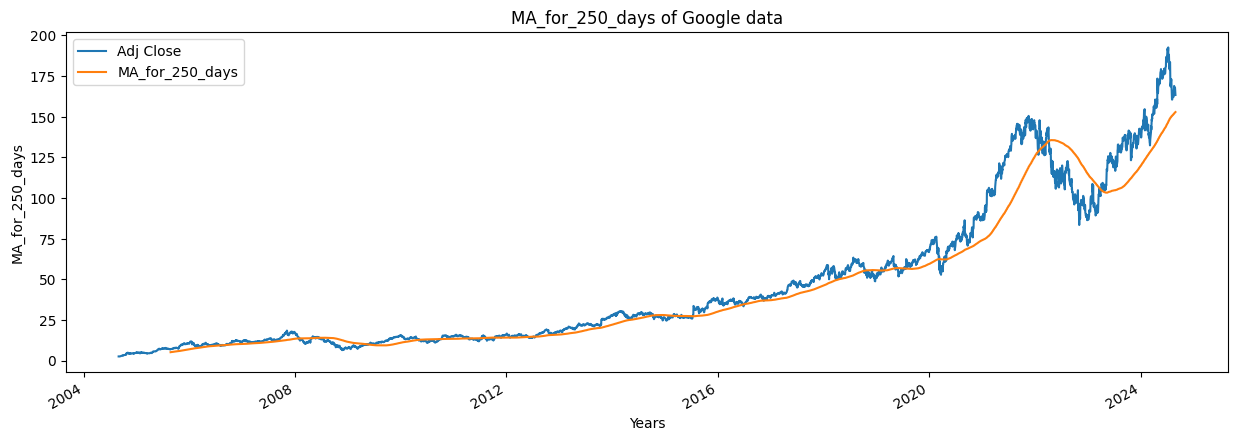

<Figure size 640x480 with 0 Axes>

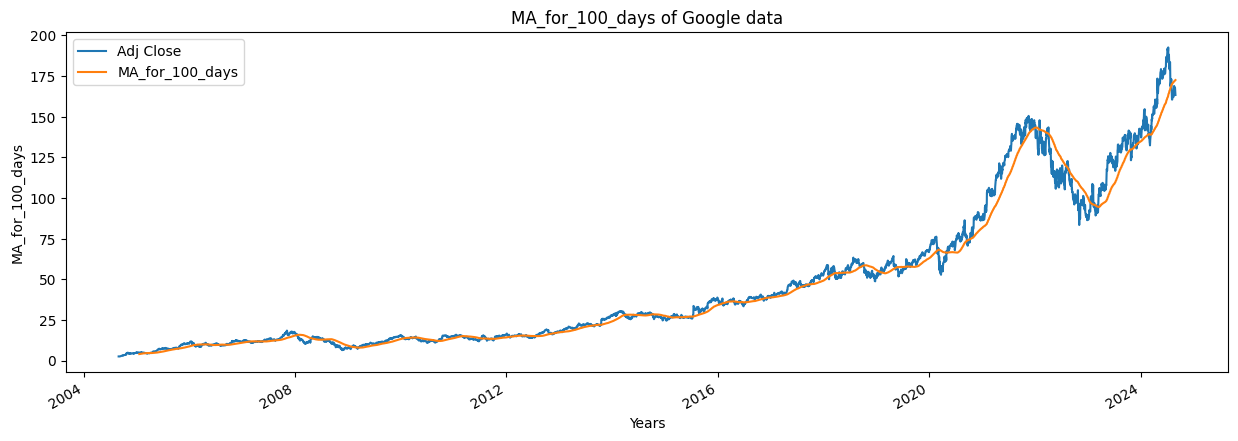

<Figure size 640x480 with 0 Axes>

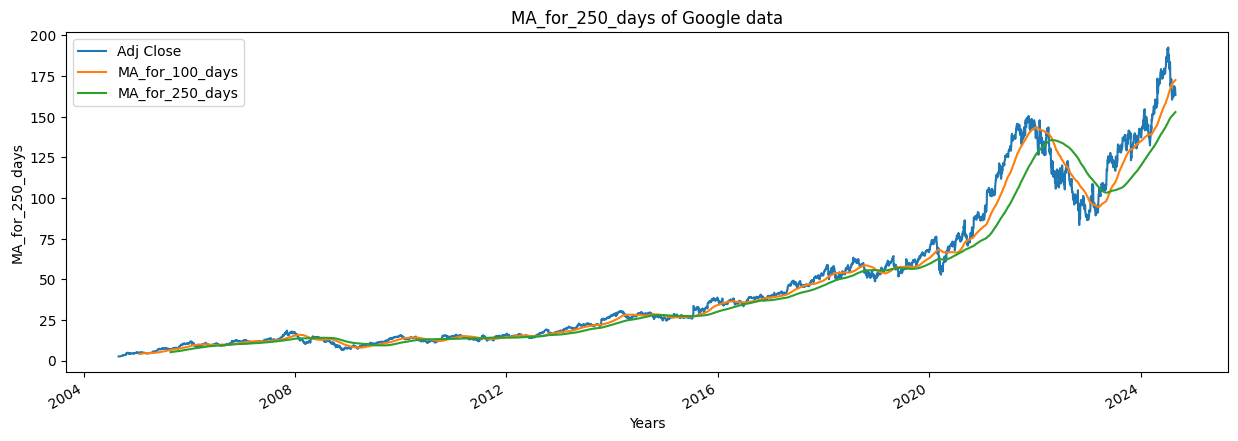

In [10]:
# Calculate 250-day and 100-day moving averages
google_data['MA_for_250_days'] = google_data['Adj Close'].rolling(250).mean()
google_data['MA_for_100_days'] = google_data['Adj Close'].rolling(100).mean()

# Plot moving averages
plot_graph((15, 5), google_data[['Adj Close', 'MA_for_250_days']], 'MA_for_250_days')
plot_graph((15, 5), google_data[['Adj Close', 'MA_for_100_days']], 'MA_for_100_days')
plot_graph((15, 5), google_data[['Adj Close', 'MA_for_100_days', 'MA_for_250_days']], 'MA_for_250_days')


# **Percentage Change**

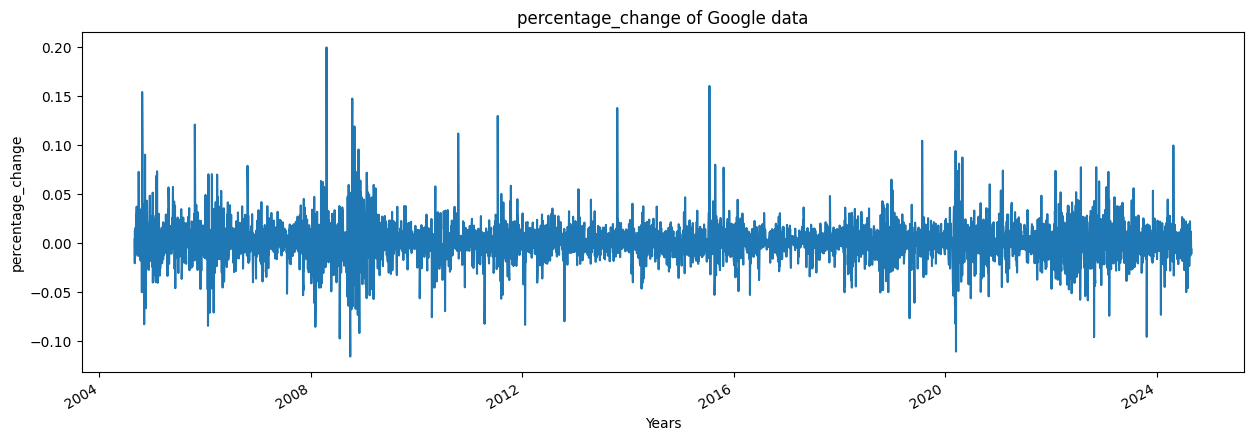

In [11]:
# Calculate percentage change
google_data['percentage_change_cp'] = google_data['Adj Close'].pct_change()
google_data[['Adj Close', 'percentage_change_cp']].head()

# Plot percentage change
plot_graph((15, 5), google_data['percentage_change_cp'], 'percentage_change')


# **Data Preprocessing for Model Training**

In [12]:
# Extract 'Adj Close' prices
Adj_close_price = google_data[['Adj Close']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Adj_close_price)

# Prepare the data for LSTM model
x_data = []
y_data = []
for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

# Split the data into training and testing sets
splitting_len = int(len(x_data) * 0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]
x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(3454, 100, 1) (3454, 1)
(1481, 100, 1) (1481, 1)


# **Model Building and Training**

In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 1.9303e-04
Epoch 2/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 5.1021e-05
Epoch 3/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 3.6790e-05
Epoch 4/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 2.4496e-05
Epoch 5/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 2.1824e-05
Epoch 6/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 2.3185e-05
Epoch 7/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 1.7176e-05
Epoch 8/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 2.1361e-05
Epoch 9/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 2.2002e-05
Epoch 10/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 1.7629e-05
Epoch 11/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 1.6660e-05
Epoch 12/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 1.5245e-05
Epoch 13/20
3454/3454 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 1.3410e-05
Epoch 14/20
3454/3454 ━━━━━━━━━━━━

#  Model Evaluation

In [15]:
model.summary()

# Make predictions on the test set
predictions = model.predict(x_test)

# Inverse transform predictions
inv_predictions = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_test)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [16]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(inv_y_test, inv_predictions)

In [17]:
mae

10.157603514347423

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    nonzero_elements = y_true != 0
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

mape = mean_absolute_percentage_error(inv_y_test, inv_predictions)

In [20]:
mape

7.774047068545377

# **Visualization of Predictions**

<Figure size 640x480 with 0 Axes>

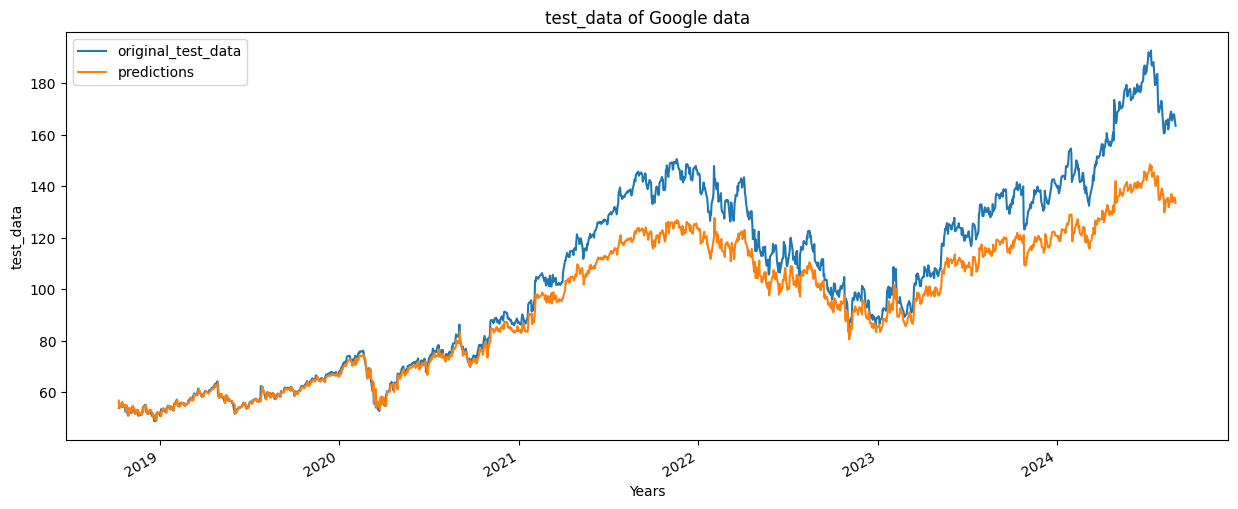

<Figure size 640x480 with 0 Axes>

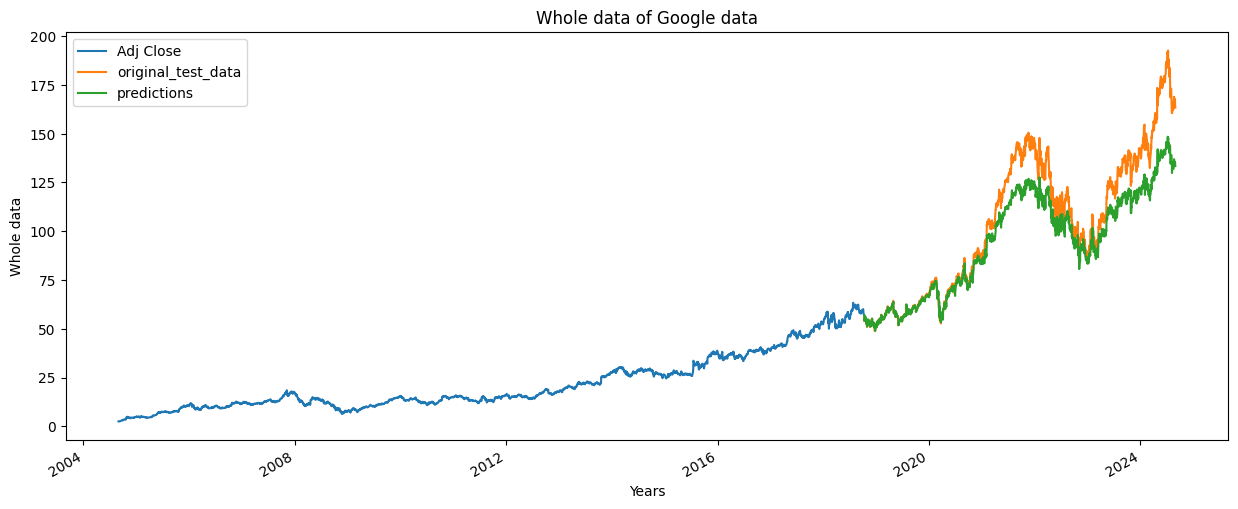

In [25]:
# Prepare data for plotting
ploting_data = pd.DataFrame(
    {
        'original_test_data': inv_y_test.reshape(-1),
        'predictions': inv_predictions.reshape(-1)
    },
    index=google_data.index[splitting_len + 100:]
)

# Plot the predictions vs original data
plot_graph((15, 6), ploting_data, 'test_data')
plot_graph((15, 6), pd.concat([Adj_close_price[:splitting_len + 100], ploting_data]), 'Whole data')


In [27]:
# Save the trained model
model.save("Latest_stock_price_model.keras")